# Step 2 — Complementary Movement

## **Goal**
Build on Step 1 by adding a “backup rule” so that when an agent fails the threshold rule,  
they can still move toward a complementary (different) neighbor before staying or moving to random.

---

## **Key Additions from Step 1**
- **anti-backtrack**: prevent unrealistic ping-pong movement between two nodes, stabilizing the diffusion and making footfall patterns more realistic  
- Add **p_move_below**: if threshold not met, move to different-category node with this probability.  
- Define a clear **stay condition**: if both fail, agent stays or makes a minimal random move within its neighbors.  
- Anchor remains fixed (e.g., node 0) to ensure consistent diffusion tracking.

---

## **Movement Logic Summary**
| Step | Condition | Action |
|------|------------|--------|
| ① | `ratio_same ≥ θ_same` | Move to a *similar* neighbor |
| ② | `ratio_same < θ_same` and random < `p_move_below` | Move to a *different* neighbor (backup rule) |
| ③ | Otherwise | Stay (or random minimal move) |

---

## **Parameter Settings**
| Parameter | Meaning | Example |
|------------|----------|----------|
| `θ_same` | Same-category ratio threshold | 0.6 |
| `p_move_below` | Probability of moving to different node below threshold | 0.4 |
| `p_stay_anchor` | Probability of staying at anchor | 0.3 |
| `steps` | Number of time ticks | 10 |
| `n_agents` | Number of customers | 100 |

---

## **Interpretation**
- When **θ_same ↑**, agents cluster near similar stores.  
- When **p_move_below ↑**, diffusion toward other categories increases.  
- Fixed anchor allows consistent measurement of footfall spread and spillover effects.

---

In [7]:
import sys, os
PROJECT_ROOT = os.path.abspath("..")   # 노트북이 notebooks/ 안에 있을 때 가정
sys.path.append(PROJECT_ROOT)
sys.path.append(os.path.join(PROJECT_ROOT, "src"))
sys.path.append(os.path.join(PROJECT_ROOT, "utils"))

print("Project root:", PROJECT_ROOT)

import numpy as np
import pandas as pd
import networkx as nx
from dataclasses import dataclass
from utils.io import ensure_dir

@dataclass
class Params:
    n_nodes: int = 20
    n_anchors: int = 1
    steps: int = 50
    theta_same: float = 0.6
    p_edge: float = 0.2
    n_agents: int = 200
    p_stay_anchor: float = 0.2
    p_move_below: float = 0.5
    anti_backtrack: bool = True
    backtrack_penalty: float = 0.5
    seed: int = 1
    count_t0: bool = True
    init_spread_ratio: float = 0.30
    agent_marker_size: int = 90
    jitter: float = 0.012
    interval_ms: int = 200

def build_mall(params: Params):
    rng = np.random.default_rng(params.seed)
    G = nx.erdos_renyi_graph(params.n_nodes, params.p_edge, seed=params.seed)
    anchors = {0}

    for n in G.nodes:
        if n in anchors:
            G.nodes[n]["role"] = "anchor"
            G.nodes[n]["category"] = "similar"
            G.nodes[n]["A"] = 3
        else:
            G.nodes[n]["role"] = "tenant"
            G.nodes[n]["category"] = rng.choice(["similar", "different"])
            G.nodes[n]["A"] = 1
    return G, anchors

def is_complement(a: str, b: str) -> bool:
    return a != b

Project root: /workspaces/Modeling


In [8]:
def simulate(params: Params):
    rng = np.random.default_rng(params.seed)
    G, anchors = build_mall(params)
    A0 = next(iter(anchors))
    footfall = np.zeros(params.n_nodes, dtype=int)

    customers = np.full(params.n_agents, A0, dtype=int)
    neighbors_A0 = list(G.neighbors(A0)) or [A0]
    k = int(params.init_spread_ratio * params.n_agents)
    if k > 0:
        idx = rng.choice(params.n_agents, size=k, replace=False)
        customers[idx] = rng.choice(neighbors_A0, size=k, replace=True)

    prev_pos = customers.copy()
    traces = []

    if params.count_t0:
        footfall += np.bincount(customers, minlength=params.n_nodes)
        traces.append(customers.copy())

    for _ in range(params.steps):
        for i in range(params.n_agents):
            here = customers[i]
            neighbors = list(G.neighbors(here)) or [here]
            curr_cat = G.nodes[here]["category"]

            same_neighbors = [v for v in neighbors if G.nodes[v]["category"] == curr_cat]
            ratio_same = len(same_neighbors) / len(neighbors)

            
            if G.nodes[here]["role"] == "anchor" and rng.random() < params.p_stay_anchor:
                nxt = here
            
            elif same_neighbors and ratio_same >= params.theta_same:
                nxt = int(rng.choice(same_neighbors))
            else:
               
                comp_neighbors = [v for v in neighbors if is_complement(curr_cat, G.nodes[v]["category"])]
                if rng.random() < params.p_move_below:
                    pool = comp_neighbors if comp_neighbors else neighbors
                    nxt = int(rng.choice(pool))
                else:
                    nxt = here

            
            if params.anti_backtrack and nxt == prev_pos[i] and rng.random() < params.backtrack_penalty:
                nxt = here

            prev_pos[i] = here
            customers[i] = nxt

        footfall += np.bincount(customers, minlength=params.n_nodes)
        traces.append(customers.copy())

    df = pd.DataFrame({
        "node": np.arange(params.n_nodes),
        "role": [G.nodes[n]["role"] for n in G.nodes],
        "category": [G.nodes[n]["category"] for n in G.nodes],
        "footfall": footfall
    })

    ensure_dir("data/outputs")
    df.to_csv("data/outputs/step2_visible.csv", index=False)
    print("[Saved] data/outputs/step2_visible.csv")

    class SimResult: ...
    sim = SimResult()
    sim.mall_graph = G
    sim.traces = traces
    sim.p = params
    return df, sim, A0

In [9]:
def animate_movement(sim, filename="figs/step2_asm.gif", pos=None, interval=400):
    import numpy as np
    import matplotlib.pyplot as plt
    import networkx as nx
    from matplotlib.animation import FuncAnimation, PillowWriter

    G, traces = sim.mall_graph, sim.traces
    if not traces: raise ValueError("sim.traces is empty")
    if pos is None: pos = nx.spring_layout(G, seed=sim.p.seed, k=0.8)

    cmap = {"anchor":"tab:red","similar":"tab:blue","different":"tab:green"}
    node_colors = [
        (cmap["anchor"] if G.nodes[n].get("role")=="anchor"
         else cmap.get(G.nodes[n].get("category"), "gray"))
        for n in G.nodes
    ]

    fig, ax = plt.subplots(figsize=(7,6)); ax.axis("off")
    nx.draw_networkx_edges(G, pos, ax=ax, alpha=.3, width=1.0)
    nx.draw_networkx_nodes(G, pos, ax=ax, node_color=node_colors, node_size=200)

    handles = [
        plt.Line2D([0],[0], marker="o", ls="", color=cmap["anchor"],   label="anchor"),
        plt.Line2D([0],[0], marker="o", ls="", color=cmap["similar"],  label="similar"),
        plt.Line2D([0],[0], marker="o", ls="", color=cmap["different"],label="different"),
        plt.Line2D([0],[0], marker="o", ls="", color="black",          label="agents"),
    ]
    ax.legend(handles=handles, loc="upper left", frameon=True)

    def XY(arr): 
        return [pos[int(n)][0] for n in arr], [pos[int(n)][1] for n in arr]
    x0, y0 = XY(traces[0])
    scat = ax.scatter(x0, y0, s=40, c="black", alpha=.85, zorder=10)
    ax.set_title("Agent movement (tick=0)")

    def update(t):
        x, y = XY(traces[t]); scat.set_offsets(np.c_[x, y])
        ax.set_title(f"Agent movement (tick={t})"); return scat,

    anim = FuncAnimation(fig, update, frames=len(traces), interval=interval, blit=False)
    writer = PillowWriter(fps=max(1, int(1000/interval)))
    anim.save(filename, writer=writer)
    plt.close(fig)
    print(f"[Saved GIF] {filename}")


if __name__ == "__main__":
    p = Params()  
    df, sim, A0 = simulate(p)
    print("Anchor fixed at node:", A0)
    print(df.sort_values("footfall", ascending=False).head())

    ensure_dir("figs")
    animate_movement(sim, filename="figs/step2_visible.gif", interval=p.interval_ms)

[Saved] data/outputs/step2_visible.csv
Anchor fixed at node: 0
    node    role   category  footfall
10    10  tenant    similar      1177
8      8  tenant  different       886
1      1  tenant    similar       885
3      3  tenant  different       738
17    17  tenant  different       690
[Saved GIF] figs/step2_visible.gif


[Saved] data/outputs/step2_visible.csv
Anchor fixed at node: 0
Total=10200 | Expected=10200
[Saved GIF] figs/step2_visible.gif


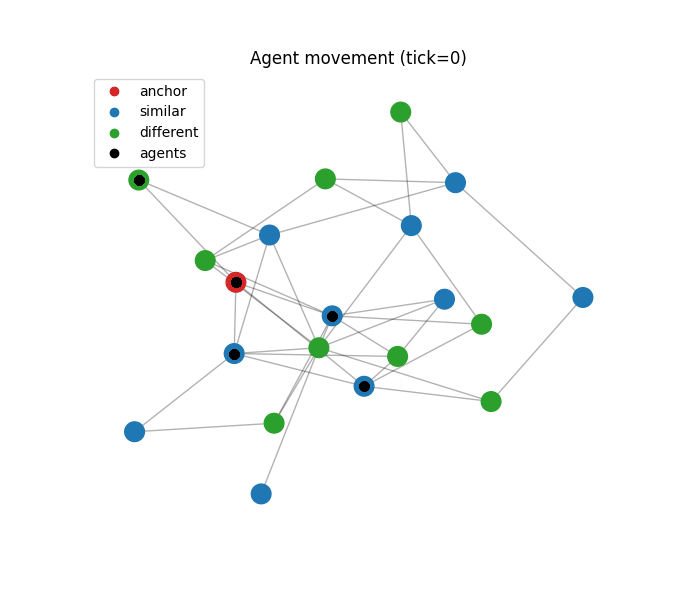

In [10]:
p = Params()
df, sim, A0 = simulate(p)
print("Anchor fixed at node:", A0)

expected = p.n_agents * (p.steps + int(p.count_t0))
print(f"Total={df.footfall.sum()} | Expected={expected}")

from IPython.display import Image, display
ensure_dir("figs")
out_path = "figs/step2_visible.gif"
animate_movement(sim, filename=out_path, interval=p.interval_ms)
display(Image(filename=out_path))


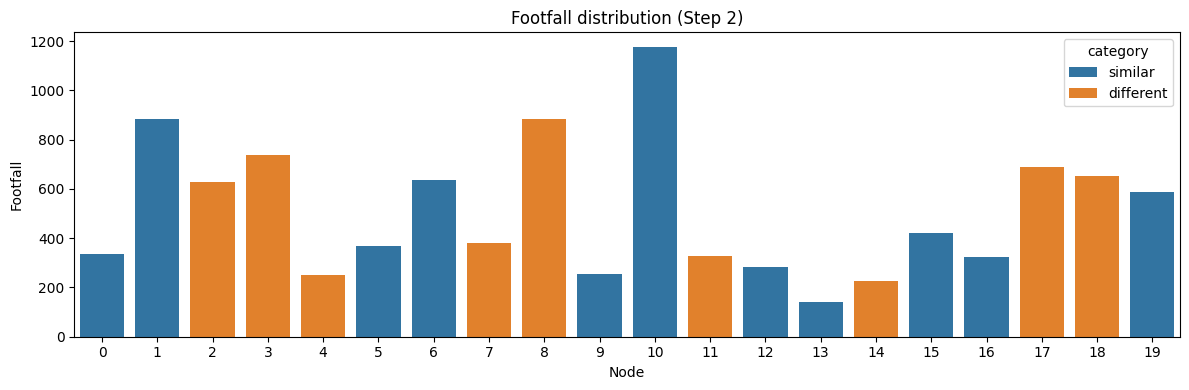

In [6]:
import matplotlib.pyplot as plt, seaborn as sns
plt.figure(figsize=(12,4))
sns.barplot(data=df.sort_values("node"),x="node",y="footfall",hue="category")
plt.title("Footfall distribution (Step 2)")
plt.xlabel("Node");plt.ylabel("Footfall")
plt.tight_layout();plt.show()


## **Step 2 — Interpretation & Summary**

### **Observations**

| Aspect | Observation | Interpretation |
|:--|:--|:--|
| **Footfall distribution** | Visits are still concentrated around a handful of key nodes (e.g., 10, 8, 1, 3) but traffic is more evenly spread around the network. | The previous over-concentration at the anchor has been relieved. |
| **Anchor (node 0)** | Medium-level foot traffic — anchor still attracts but with diffusion | With `p_stay_anchor = 0.2`, agents remain in one place and wander around |
| **Similar vs Different** | Similar nodes continue to dominate, but traffic on dissimilar nodes rises significantly | `θ_same = 0.6` and `p_move_below = 0.5` preserve clustering with the re-emergence of complementary diffusion |
| **Agent movement (GIF)** | AAgents begin to cluster near the anchor, gradually propagating slowly to green (alternative) nodes | omplementary movement is initiated and anti-backtrack stabilizes routes |

---

### **Interpretation**

- The interaction of **threshold** and **complementary-movement rules** shifts the system
  away from an entirely anchor-focused pattern to a **balanced diffusion model**.
- **Anti-backtrack** removes unrealistic flip-flopping between two nodes
leading to smoother and more authentic footfall patterns across the network.
- Overall, Step 2 achieves both **functional diffusion** and **social clustering**,
improving behavioral realism compared to Step 1.

---

## **Step 2 vs Step 3 — Comparative Insights**

| Dimension | **Step 2 – Complement Rule** | **Step 3 – Visibility / Attractiveness** |
|:--|:--|:--|
| **Logic center** | Threshold + Complementary + Anti-backtrack | Threshold + Spatial Visibility / Distance Weight |
| **Model emphasis** | Behavioral realism ↑ – recovering mobility | Spatial realism ↑ – responding to store layout & distance |
| **Pattern of footfall** | Balanced diffusion around the anchor | Re-concentration into key "hot-spot" areas
| **Managerial insight** | Increases anchor - complementary store linkage → increased dwell time | Leverages visibility / positioning to focus strategic traffic most efficiently |
| **Analytical perspective** | "Behavior-based" simulation | "Behavior + Space" combined model |


---

## **Managerial Insight**

- Step 2 incorporates behavioral flexibility, providing a more realistic customer flow within the mall.
- With Step 3 contributing **spatial factors** such as visibility and distance,
it supports quantitative analysis of **anchor effects**, **zone attractiveness**,  
and **layout-based traffic optimization**.